## 1. Regresion Analysis with random forest
### 12 games, cross-validation 6 folds
## 2. Correlation matrix

Cross-Validation Results:
RMSE scores: [ 9.66552018 42.32650089 14.94770403  3.75726751 21.97303176 12.76765171]
Mean RMSE: 17.57 (+/- 12.35)

Traditional Feature Importance:
                        feature  importance
0                   Num_Actions    0.443543
4             Compression_Ratio    0.213261
1             Trajectory_Length    0.103108
5                 Feature_Count    0.093484
3                 Image_Entropy    0.092782
2  Steps_to_1st_non-zero_Reward    0.053821


/tmp/ipykernel_48098/1754830435.py:86: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(feature_importance['feature'], rotation=45, ha='right', fontsize=17, fontweight='medium')
/tmp/ipykernel_48098/1754830435.py:87: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=17, fontweight='medium')


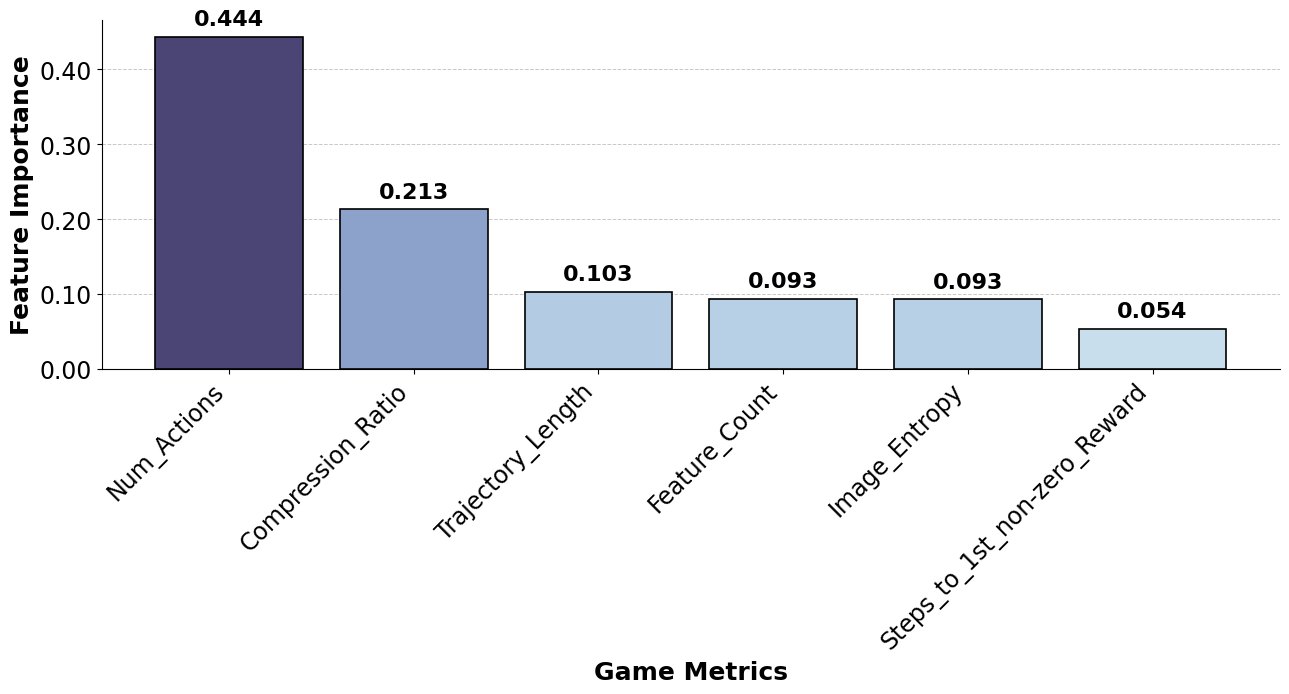

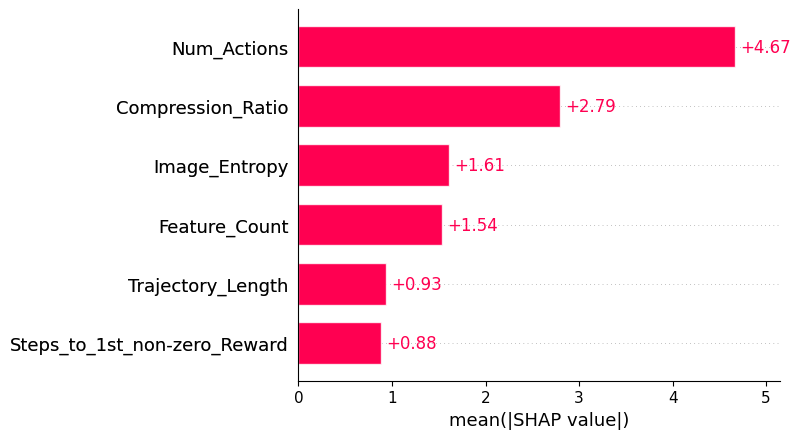

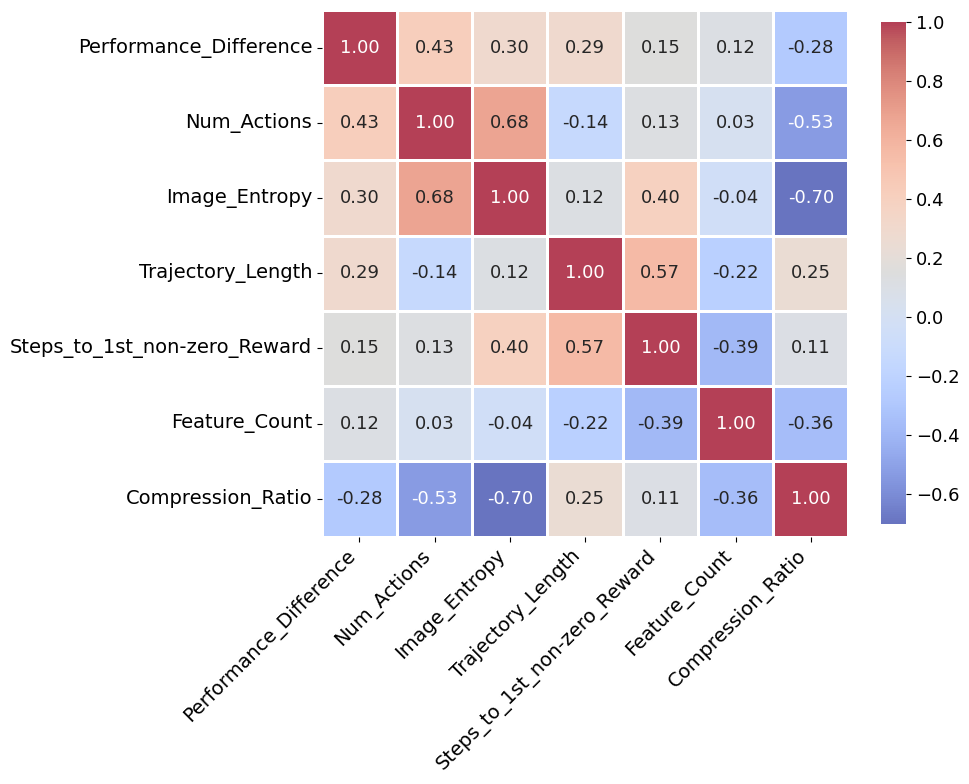

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import seaborn as sns
import shap

# Prepare the data
games = ['Breakout', 'Qbert', 'Hero', 'KungFuMaster', 'Pong', 'Seaquest', 'Alien', 'BankHeist', 'BattleZone', 'RoadRunner', 'SpaceInvaders', 'FishingDerby']
dt_scores = [309.14, 36.98, 30.37, 29.41, 71.58, 2.05, 12.42, 0.63, 9.49, 25.00, 26.06, 160.44]
dm_scores = [367.13, 26.93, 7.77, 5.29, 64.31, 2.77, 11.74, -0.09, 7.20, 28.49, 28.77, 153.14]
num_actions = [4, 6, 18, 14, 6, 18, 18, 18, 18, 18, 6, 18]
avg_trajectory_length = [1299.62, 1060.84, 1192.23, 2642.71, 2096.52, 1413.12, 932.20, 1185.34, 2068.26, 1123.01, 1820.79, 1775.02]
avg_steps_to_first_non_zero_reward = [45.20, 56.75, 54.94, 109.53, 112.64, 87.23, 22.49, 20.04, 267.60, 81.03, 52.07, 44.58]
image_entropy = [1.50, 1.89, 2.01, 2.66, 0.68, 2.24, 2.02, 1.88, 2.84, 1.77, 0.84, 2.20]
compression_ratio = [21.35, 5.80, 10.55, 7.58, 40.00, 12.92, 7.71, 7.78, 9.31, 12.89, 13.30, 8.01]
feature_count = [23.33, 84.64, 38.84, 52.63, 9.16, 16.18, 22.88, 188.87, 13.88, 24.61, 65.85, 23.34]

data = pd.DataFrame({
    'Game': games,
    'DT_Score': dt_scores,
    'DM_Score': dm_scores,
    'Num_Actions': num_actions,
    'Trajectory_Length': avg_trajectory_length,
    'Steps_to_1st_non-zero_Reward': avg_steps_to_first_non_zero_reward,
    'Image_Entropy': image_entropy,
    'Compression_Ratio': compression_ratio,
    'Feature_Count': feature_count
})

# Calculate performance difference (DT - DM)
data['Performance_Difference'] = data['DT_Score'] - data['DM_Score'] 

# Prepare features (X) and target variable (y)
X = data[['Num_Actions', 'Trajectory_Length', 'Steps_to_1st_non-zero_Reward', 
          'Image_Entropy', 'Compression_Ratio', 'Feature_Count']]
y = data['Performance_Difference']


"""
Random Forest Regression
"""
# Random Forest Regression model, 6-fold cross-validation
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
cv = KFold(n_splits=6, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='neg_mean_squared_error')

# Convert MSE to RMSE and make positive
rmse_scores = np.sqrt(-cv_scores)
print("Cross-Validation Results:")
print("RMSE scores:", rmse_scores)
print("Mean RMSE: {:.2f} (+/- {:.2f})".format(rmse_scores.mean(), rmse_scores.std()))

# Fit the model
rf.fit(X, y)


"""
Analysis Features Importance (Traditional)
"""
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

print("\nTraditional Feature Importance:")
print(feature_importance)

# Plot traditional feature importance
norm = plt.Normalize(min(feature_importance['importance']), max(feature_importance['importance']))
colors = sns.color_palette("ch:s=.22,rot=-.22, light=0.85, dark=0.3", as_cmap=True)
palette = [colors(norm(value)) for value in feature_importance['importance']]

# Set up the figure and axis
plt.figure(figsize=(13, 7))
ax = plt.gca()
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7, zorder=0)

# Create the bar plot
bars = ax.bar(feature_importance['feature'], feature_importance['importance'], 
              color=palette, edgecolor='black', linewidth=1.2, width=0.8, zorder=3)

ax.set_ylabel('Feature Importance', fontsize=18, fontweight='bold')
ax.set_xlabel('Game Metrics', fontsize=18, fontweight='bold')
ax.set_xticklabels(feature_importance['feature'], rotation=45, ha='right', fontsize=17, fontweight='medium')
ax.set_yticklabels(ax.get_yticks(), fontsize=17, fontweight='medium')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add labels on bars
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{bar.get_height():.3f}', 
            ha='center', va='bottom', fontsize=16, fontweight='bold')

# Set a format for y-axis tick labels to avoid cluttering
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.2f}'))
plt.tight_layout()
plt.savefig('feature_importance.pdf', dpi=300)

"""
SHAP Feature Importance 
"""
plt.figure(figsize=(13, 7))
explainer = shap.Explainer(rf, X)
shap_values = explainer(X, check_additivity=False)
shap.plots.bar(shap_values, show=False)
plt.tight_layout()
plt.savefig('shap_feature_importance.pdf', dpi=300)


# explainer = shap.TreeExplainer(rf)
# shap_values = explainer.shap_values(X)

# # Create summary plot
# plt.figure(figsize=(13, 7))
# shap.summary_plot(shap_values, X, plot_type="bar", show=False)

# plt.xlabel("Mean(|SHAP value|)", fontsize=14, color='black')
# plt.ylabel("Features", fontsize=14, color='black')

# # Adding data labels to each bar
# for bar in ax.patches:
#     ax.text(
#         bar.get_width(),  # x-coordinate position of the text
#         bar.get_y() + bar.get_height()/2,  # y-coordinate position of the text
#         f'{bar.get_width():.2f}',  # Text label with formatting
#         va='center',  # Center the text vertically on the bar
#         ha='left',  # Align the text to the left of the bar
#         fontsize=12,  # Font size of the text
#         color='black',  # Color of the text
#         fontweight='bold'  # Font weight of the text
#     )

# plt.tight_layout()
# plt.savefig('shap_feature_importance.pdf', dpi=300)


"""
Correlation Matrix
"""
# Create a function to adjust the saturation of colors
def adjust_saturation(color, saturation_scale):
    from matplotlib.colors import rgb_to_hsv, hsv_to_rgb
    rgb = plt.cm.colors.to_rgb(color)
    hsv = rgb_to_hsv(rgb) 
    hsv[1] *= saturation_scale  
    return hsv_to_rgb(hsv)  

# set colormap
n_colors = 256
original_cmap = plt.cm.coolwarm
lower_saturation_cmap = ListedColormap([adjust_saturation(original_cmap(i), 0.66) for i in range(n_colors)])

correlation_matrix = data.drop(['Game', 'DT_Score', 'DM_Score'], axis=1).corr()
sorted_features = correlation_matrix['Performance_Difference'].sort_values(ascending=False).index.tolist()
sorted_features.remove('Performance_Difference')
sorted_features = ['Performance_Difference'] + sorted_features
correlation_matrix = correlation_matrix.loc[sorted_features, sorted_features]

# Create the heatmap
plt.figure(figsize=(10, 9))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=lower_saturation_cmap, 
            square=True, linewidths=.8, cbar_kws={"shrink": .75}, 
            annot_kws={"fontsize": 13, "fontweight": "medium"})

# colorbar
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=13)

plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(rotation=0, fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('correlation_matrix.pdf', dpi=300)
